In [1]:
import pandas as pd
import yfinance as yf
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

In [2]:
cba = yf.download("CBA.AX", start="2015-01-01", end="2023-12-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
cba

Price,Close,High,Low,Open,Volume
Ticker,CBA.AX,CBA.AX,CBA.AX,CBA.AX,CBA.AX
Date,,,,,
2015-01-02,53.524395,53.524395,53.137355,53.324631,949439
2015-01-05,53.655495,53.836531,53.380818,53.499431,1351651
2015-01-06,53.249733,53.561866,52.981301,53.124881,2477275
2015-01-07,53.131123,53.368343,52.781534,53.255975,2127190
2015-01-08,53.305897,53.468205,53.143588,53.399537,1997761
...,...,...,...,...,...
2023-12-21,106.583923,106.873137,106.053707,106.747815,2830850
2023-12-22,106.526085,106.844219,106.198316,106.227236,3097447


In [4]:
#Feature Engineering
def add_features(df):
    # Use only past data for feature calculations
    df['5_day_MA'] = df['Close'].rolling(5).mean()  # 5-day moving average
    df['30_day_MA'] = df['Close'].rolling(30).mean()  # 30-day moving average
    df['Daily_Return'] = df['Close'].pct_change()  # Daily percentage return
    df['Volatility'] = df['Daily_Return'].rolling(14).std()  # 14-day volatility

    # Target: Next day's closing price
    df['Target'] = df['Close'].shift(-1)

    # Drop rows with missing values
    df.dropna(inplace=True)
    return df


In [5]:
# Apply feature engineering
cba = add_features(cba)

# 3. Prepare Features and Target
X = cba[['5_day_MA', '30_day_MA', 'Volatility']]  # Features
y = cba['Target']  # Target (next day's closing price)



In [6]:
# 4. Time-Series Split (No Shuffling!)
split_idx = int(len(cba) * 0.8)  # 80% training, 20% testing
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

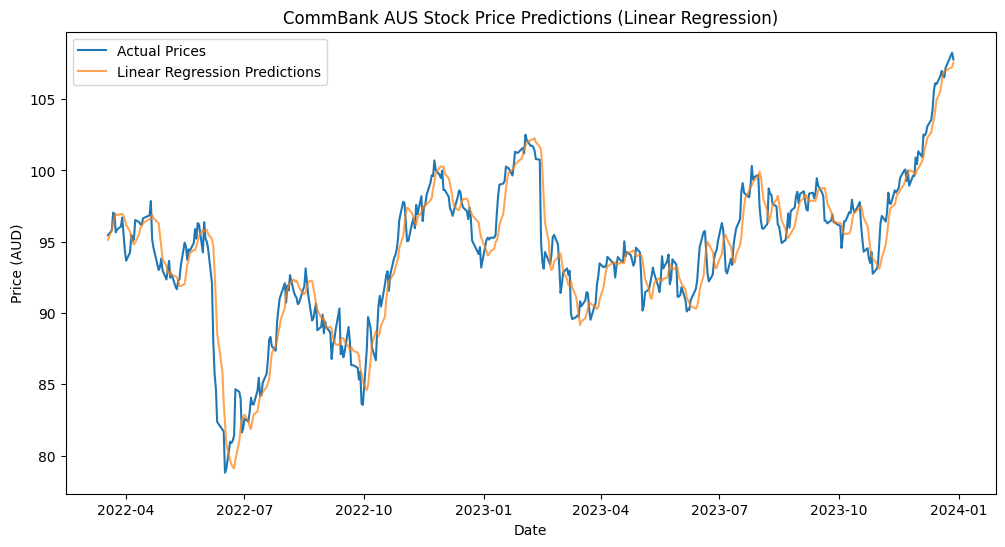

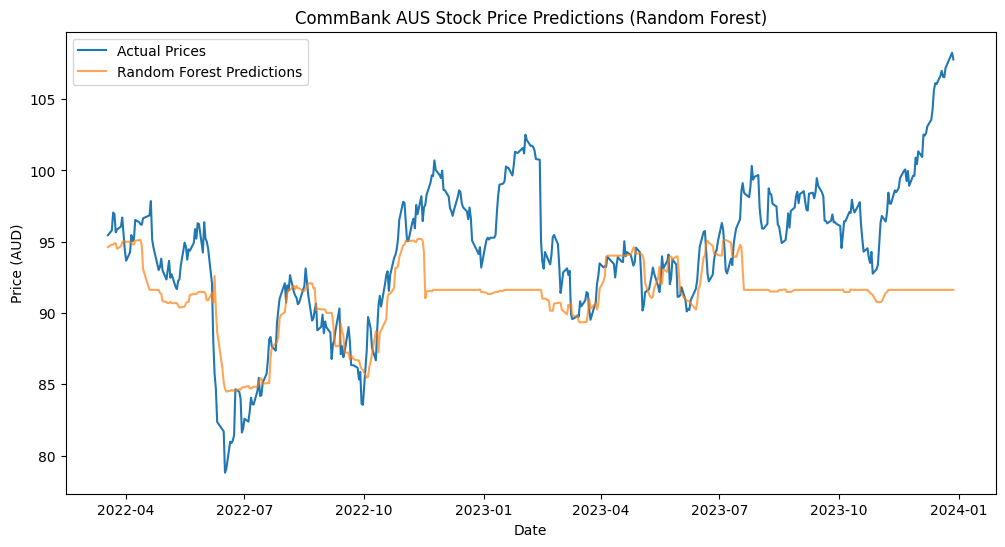

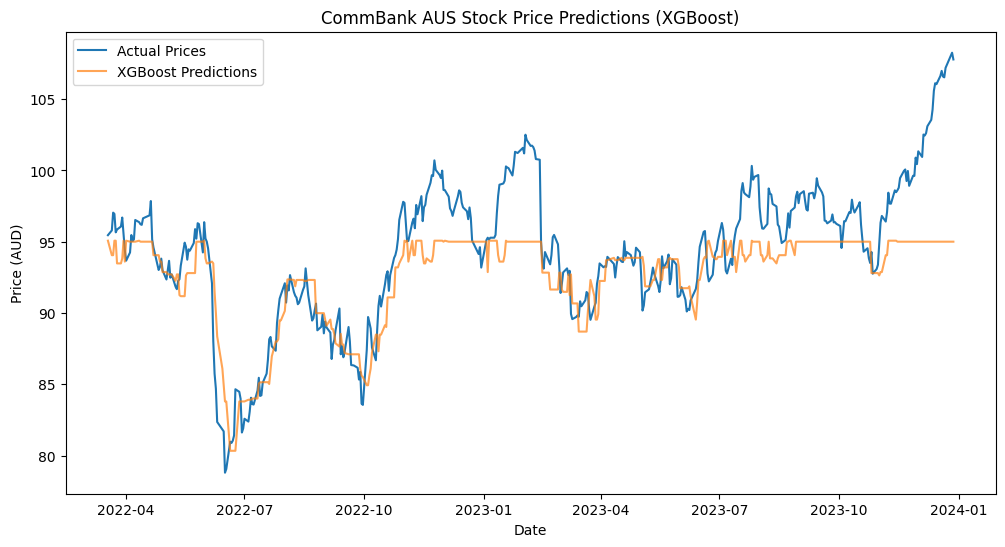

In [7]:
#Train and Evaluate Models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=50, max_depth=5, random_state=42),  # Regularized
    "XGBoost": XGBRegressor(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42)  # Regularized
}

results = {}
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # Evaluate performance
    train_r2 = r2_score(y_train, train_preds)
    test_r2 = r2_score(y_test, test_preds)
    train_mse = mean_squared_error(y_train, train_preds)
    test_mse = mean_squared_error(y_test, test_preds)

    # Store results
    results[name] = {
        "Train R²": train_r2,
        "Test R²": test_r2,
        "Train MSE": train_mse,
        "Test MSE": test_mse
    }

    # Plot predictions vs actual for test data
    plt.figure(figsize=(12,6))
    plt.plot(y_test.index, y_test.values, label="Actual Prices")
    plt.plot(y_test.index, test_preds, label=f"{name} Predictions", alpha=0.7)
    plt.title(f"CommBank AUS Stock Price Predictions ({name})")
    plt.xlabel("Date")
    plt.ylabel("Price (AUD)")
    plt.legend()
    plt.show()

In [8]:
#Compare Model Performance
print("\n--- Model Performance Comparison ---")
for name, metrics in results.items():
    print(f"\n{name}:")
    print(f"  Train R²: {metrics['Train R²']:.2f}")
    print(f"  Test R²: {metrics['Test R²']:.2f}")
    print(f"  Train MSE: {metrics['Train MSE']:.2f}")
    print(f"  Test MSE: {metrics['Test MSE']:.2f}")



--- Model Performance Comparison ---

Linear Regression:
  Train R²: 0.99
  Test R²: 0.90
  Train MSE: 1.48
  Test MSE: 2.56

Random Forest:
  Train R²: 0.99
  Test R²: -0.01
  Train MSE: 1.16
  Test MSE: 25.10

XGBoost:
  Train R²: 0.99
  Test R²: 0.56
  Train MSE: 1.15
  Test MSE: 10.92
